# Permutation Flow-Shop Scheduling Problem

This is a variant of the Flot-shop scheduling problem (FSSP) in which the sequence of jobs is the same in every machine.

$$
 \begin{align}
     \text{min} \quad & C_{\text{max}} \\
     \text{s.t.} \quad & x_{m-1, j} + p_{m, j} \leq x_{m, j}
         & \forall ~ j \in J; m \in (2, ..., |M|)\\
     & x_{m, j} + p_{m, j} \leq x_{m, k} \lor x_{m, k} + p_{m, k} \leq x_{m, j}
         & \forall ~ j \in J; k \in J, j \neq k\\
     & x_{|M|, j} + p_{|M|, j} \leq C_{\text{max}}
         & \forall ~ j \in J\\
     & x_{m, j} \geq 0 & \forall ~ j \in J; m \in M\\
     & z_{j, k} \in \{0, 1\} & \forall ~ j \in J; k \in J, j \neq k\\
 \end{align}
 $$

 You can compare this implementation to MILP solvers at the [end of the notebook](#bonus---milp-model).

In [1]:
from bnbprob.pafssp import LazyBnB, PermFlowShop, plot_gantt
from bnbpy import configure_logfile, plot_tree

In [2]:
configure_logfile("pafssp.log", mode="w")

In [3]:
p = [
    [5, 9, 7, 4],
    [9, 3, 3, 8],
    [8, 10, 5, 6],
    [1, 8, 6, 2]
]

In [7]:
problem = PermFlowShop.from_p(p)
bnb = LazyBnB(eval_node="in", rtol=0.0001, save_tree=True)

In [8]:
problem.get_sigma1_mach_graph()

In [9]:
sol = bnb.solve(problem, maxiter=50000)
print(sol)

Status: OPTIMAL | Cost: 43.0 | LB: 43.0


In [10]:
bnb.incumbent.problem.get_mach_graph()

MachineGraph(M=4, prec=[[], [0], [1], [2]], succ=[[1], [2], [3], []], topo_order=[0, 1, 2, 3], rev_topo_order=[3, 2, 1, 0], chains=[[0, 1, 2, 3]])

In [8]:
bnb.incumbent.problem.get_mach_graph()

MachGraphInterface(m=4, prec=[[], [0], [1], [2]], succ=[[1], [2], [3], []], topo_order=[0, 1, 2, 3], rev_topo_order=[3, 2, 1, 0])

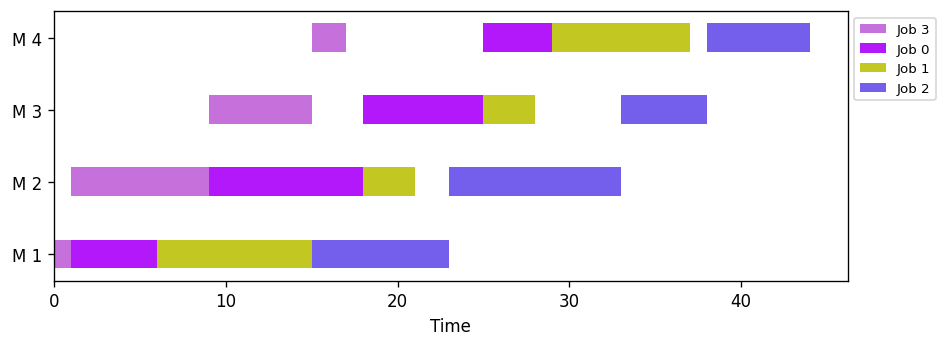

In [6]:
plot_gantt(sol.sequence, dpi=120, seed=42, figsize=[8, 3])

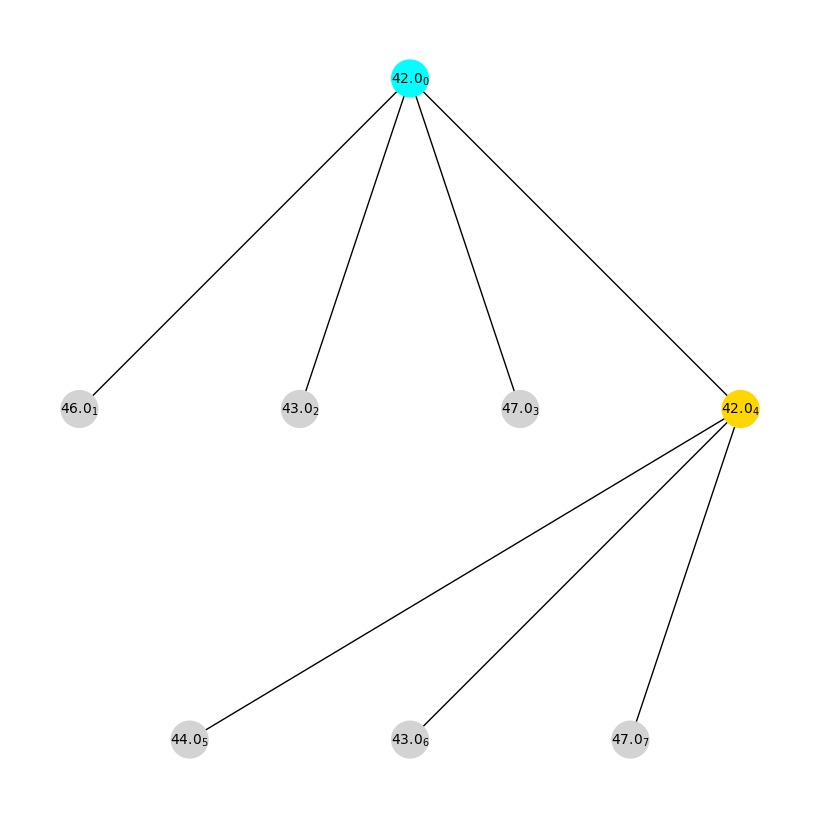

In [80]:
plot_tree(bnb.root, figsize=[8, 8], font_size=10)

In this implmentation lower bounds are computed by
the max of a single machine and
a two machine relaxations.

The bounds for single and two-machine problems are described
by Potts (1980), also implemented by Ladhari & Haouari (2005),
therein described as 'LB1' and 'LB5'.

If the attribute `constructive` is 'neh', the heuristic
of Nawaz et al. (1983) is adopted, otherwise
the strategy by Palmer (1965).


## References

Ladhari, T., & Haouari, M. (2005). A computational study of
the permutation flow shop problem based on a tight lower bound.
Computers & Operations Research, 32(7), 1831-1847.

Nawaz, M., Enscore Jr, E. E., & Ham, I. (1983).
A heuristic algorithm for the m-machine,
n-job flow-shop sequencing problem.
Omega, 11(1), 91-95.

Potts, C. N. (1980). An adaptive branching rule for the permutation
flow-shop problem. European Journal of Operational Research, 5(1), 19-25.

Palmer, D. S. (1965). Sequencing jobs through a multi-stage process
in the minimum total time—a quick method of obtaining a near optimum.
Journal of the Operational Research Society, 16(1), 101-107

## Bonus - MILP Model

This is the usual Position-based MILP model as an alternative to compare performance.


```python
import pyomo.environ as pyo

from bnbprob.pfssp.mip import positional_model

model = positional_model(p)


# HiGHS
solver = pyo.SolverFactory("appsi_highs")
solver.options["mip_heuristic_effort"] = 0.1
solver.options["time_limit"] = 120
solver.options["log_file"] = "Highs.log"
solver.solve(model, tee=True)

# Gurobi
solver = pyo.SolverFactory("gurobi", solver_io="python")
solver.options["Heuristics"] = 0.2
solver.options["Cuts"] = 2
solver.options["TimeLimit"] = 120
solver.solve(model, tee=True)
```